In [1]:
import numpy as np
import gym 
import tensorflow as tf
import tf_slim as slim
from collections import deque,Counter 
import random 
from datetime import datetime 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40)
%matplotlib inline
import math
import glob
import io
import base64
from matplotlib import animation
from IPython import display as ipythondisplay

In [2]:
color=np.array([210,164,74]).mean()

def preprocess_observation(observation):
    #crop
    image=observation[1:176:2,::2]
    #convert the image to grayscale
    image=image.mean(axis=2)
    #to increase the image contrast
    image[image==color]=0
    image=(image-128)/127
    
    return image.reshape(88,80,1)

In [3]:
environment=gym.make("MsPacman-v0")
n_outputs=environment.action_space.n
print('No of possible moves in the Pacman game is {}'.format(n_outputs))
print("Those moves are:")
moves_meaning=environment.env.get_action_meanings()
i=1
for move in moves_meaning:
    print("\t{0}:{1}".format(i,move))
    i+=1

No of possible moves in the Pacman game is 9
Those moves are:
	1:NOOP
	2:UP
	3:RIGHT
	4:LEFT
	5:DOWN
	6:UPRIGHT
	7:UPLEFT
	8:DOWNRIGHT
	9:DOWNLEFT


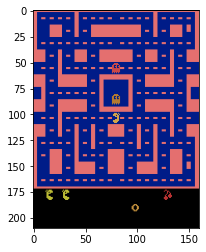

In [4]:
observation=environment.reset()
for j in range(22):
    if j>20:
        plt.imshow(observation)
        plt.show()
        
    observation,_, _, _=environment.step(1)
    

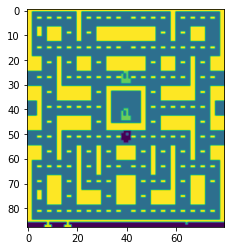

In [5]:
observation_preporcessed=preprocess_observation(observation).reshape(88,80)
plt.imshow(observation_preporcessed)
plt.show()

In [6]:
def q_network(X,name_scope):
    initializer = tf.keras.initializers.VarianceScaling(scale=2.0)
    
    with tf.compat.v1.variable_scope(name_scope) as scope:
        layer_1=slim.conv2d(X,num_outputs=64,kernel_size=(8,8),stride=4,padding='SAME',weights_initializer=initializer)
        tf.compat.v1.summary.histogram('layer_1',layer_1)
        
        layer_2=slim.conv2d(layer_1,num_outputs=64,kernel_size=(4,4),stride=2,padding='SAME',weights_initializer=initializer)
        tf.compat.v1.summary.histogram('layer_2',layer_2)
        
        layer_3=slim.conv2d(layer_2,num_outputs=64,kernel_size=(3,3),stride=1,padding='SAME',weights_initializer=initializer)
        tf.compat.v1.summary.histogram('layer_3',layer_3)
        
        flaten=slim.flatten(layer_3)
        fully_connected=slim.fully_connected(flaten,num_outputs=128,weights_initializer=initializer)
        tf.compat.v1.summary.histogram('fully_connected',fully_connected)
        output=slim.fully_connected(fully_connected,num_outputs=n_outputs,activation_fn=None,weights_initializer=initializer)
        tf.compat.v1.summary.histogram('output',output)
        
        vars={v.name[len(scope.name):]: v for v in tf.compat.v1.get_collection(key=tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)}
        
        return vars,output

In [7]:
epsilon=0.5
epsilon_max=1.0
epsilon_min=0.05
epsilon_decay_steps=500000

def epsilon_greedy(action,step):
    p=np.random.random(1).squeeze()
    epsilon=max(epsilon_min,epsilon_max-(epsilon_max-epsilon_min)*step/epsilon_decay_steps)
    if np.random.rand()<epsilon:
        return np.random.randint(n_outputs)
    else:
        return action

In [8]:
buffer_len=20000
exp_buffer=deque(maxlen=buffer_len)

def sample_memories(batch_size):
    parm_batch=np.random.permutation(len(exp_buffer))[:batch_size]
    mem=np.array(exp_buffer)[parm_batch]
    return mem[:,0],mem[:,1],mem[:,2],mem[:,3],mem[:,4]

In [9]:
num_episodes=800
batch_size=48
input_shape=(None,88,80,1)
learning_rate=0.001
x_shape=(None,88,80,1)
discount_factor=0.97

global_step=0
copy_steps=100
steps_train=4
start_steps=2000

In [10]:
log_dir="logs"
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()
X = tf.compat.v1.placeholder(tf.float32, shape=x_shape)
in_training_mode = tf.compat.v1.placeholder(tf.bool)

In [11]:
mainQ,mainQ_outputs=q_network(X,'mainQ')
targetQ,targetQ_outputs=q_network(X,'targetQ')

In [12]:
x_action=tf.compat.v1.placeholder(tf.int32,shape=(None,))
q_action=tf.reduce_sum(input_tensor=targetQ_outputs*tf.one_hot(x_action,n_outputs),axis=1,keepdims=True)

In [13]:
copy_op=[tf.compat.v1.assign(main_name,targetQ[var_name]) for var_name, main_name in mainQ.items()]
copy_target_to_main=tf.group(*copy_op)

In [14]:
y=tf.compat.v1.placeholder(tf.float32,shape=(None,1))

loss=tf.reduce_mean(input_tensor=tf.square(y-q_action))
optimizer=tf.compat.v1.train.AdadeltaOptimizer(learning_rate)
traning_optimizer=optimizer.minimize(loss)

init=tf.compat.v1.global_variables_initializer()
loss_summary=tf.compat.v1.summary.scalar('LOSS',loss)
merge_summary=tf.compat.v1.summary.merge_all()
file_writer=tf.compat.v1.summary.FileWriter(log_dir,tf.compat.v1.get_default_graph())

In [18]:
with tf.compat.v1.Session() as sess:
    init.run()
    
    history=[]
    for i in range(num_episodes):
        done=False
        observation=environment.reset()
        epoch=0
        episodic_reward=0
        actions_counter=Counter()
        episodic_loss=[]
        
        while not done:
            
            observation=preprocess_observation(observation)
            actions=mainQ_outputs.eval(feed_dict={X:[observation],in_training_mode:False})
            
            action=np.argmax(actions,axis=-1)
            actions_counter[str(action)]+=1
            
            action=epsilon_greedy(action,global_step)
            next_observation, reward, done, _= environment.step(int(action))
            exp_buffer.append([observation,action,preprocess_observation(next_observation),reward,done])
            
            if global_step%steps_train==0 and global_step>start_steps:
                o_obs,o_act,o_next_obs,o_rew,o_done=sample_memories(batch_size)
                
                o_obs=[x for x in o_obs]
                o_next_obs=[x for x in o_next_obs]
                
                next_act=mainQ_outputs.eval(feed_dict={X:o_next_obs,in_training_mode:False})
                
                y_batch=o_rew+discount_factor*np.max(next_act,axis=-1)*(1-o_done)
                
                merg_summary=merge_summary.eval(feed_dict={X:o_obs,y:np.expand_dims(y_batch,axis=-1),x_action:o_act,in_training_mode:False})
                file_writer.add_summary(merg_summary,global_step)
                
                train_loss,_=sess.run([loss,traning_optimizer],feed_dict={X:o_obs,y:np.expand_dims(y_batch,axis=-1),x_action:o_act,in_training_mode:False})
                episodic_loss.append(train_loss)
                
            if(global_step+1)%copy_steps==0 and global_step>start_steps:
                copy_target_to_main.run()
            
            observation=next_observation
            epoch+=1
            global_step+=1
            episodic_reward+=reward
        if(len(history)>800):
            break
        history.append(episodic_reward)
        print("Epochs per episode:{} Episode Reward:{} Episode Number:{}".format(epoch,episodic_reward,len(history)))

Epochs per episode:655 Episode Reward:150.0 Episode Number:1
Epochs per episode:658 Episode Reward:200.0 Episode Number:2
Epochs per episode:577 Episode Reward:210.0 Episode Number:3
Epochs per episode:666 Episode Reward:180.0 Episode Number:4
Epochs per episode:725 Episode Reward:240.0 Episode Number:5
Epochs per episode:713 Episode Reward:210.0 Episode Number:6
Epochs per episode:657 Episode Reward:170.0 Episode Number:7
Epochs per episode:626 Episode Reward:170.0 Episode Number:8
Epochs per episode:721 Episode Reward:230.0 Episode Number:9
Epochs per episode:705 Episode Reward:140.0 Episode Number:10
Epochs per episode:651 Episode Reward:190.0 Episode Number:11
Epochs per episode:680 Episode Reward:220.0 Episode Number:12
Epochs per episode:602 Episode Reward:210.0 Episode Number:13
Epochs per episode:576 Episode Reward:120.0 Episode Number:14
Epochs per episode:680 Episode Reward:170.0 Episode Number:15
Epochs per episode:662 Episode Reward:180.0 Episode Number:16
Epochs per episod

Epochs per episode:779 Episode Reward:210.0 Episode Number:133
Epochs per episode:552 Episode Reward:170.0 Episode Number:134
Epochs per episode:629 Episode Reward:200.0 Episode Number:135
Epochs per episode:606 Episode Reward:230.0 Episode Number:136
Epochs per episode:605 Episode Reward:200.0 Episode Number:137
Epochs per episode:564 Episode Reward:180.0 Episode Number:138
Epochs per episode:649 Episode Reward:170.0 Episode Number:139
Epochs per episode:526 Episode Reward:140.0 Episode Number:140
Epochs per episode:535 Episode Reward:160.0 Episode Number:141
Epochs per episode:590 Episode Reward:210.0 Episode Number:142
Epochs per episode:708 Episode Reward:320.0 Episode Number:143
Epochs per episode:1028 Episode Reward:1030.0 Episode Number:144
Epochs per episode:847 Episode Reward:650.0 Episode Number:145
Epochs per episode:695 Episode Reward:250.0 Episode Number:146
Epochs per episode:552 Episode Reward:150.0 Episode Number:147
Epochs per episode:523 Episode Reward:110.0 Episode N

Epochs per episode:760 Episode Reward:320.0 Episode Number:263
Epochs per episode:834 Episode Reward:650.0 Episode Number:264
Epochs per episode:785 Episode Reward:210.0 Episode Number:265
Epochs per episode:667 Episode Reward:190.0 Episode Number:266
Epochs per episode:926 Episode Reward:1000.0 Episode Number:267
Epochs per episode:678 Episode Reward:200.0 Episode Number:268
Epochs per episode:694 Episode Reward:360.0 Episode Number:269
Epochs per episode:762 Episode Reward:210.0 Episode Number:270
Epochs per episode:871 Episode Reward:1070.0 Episode Number:271
Epochs per episode:537 Episode Reward:190.0 Episode Number:272
Epochs per episode:739 Episode Reward:290.0 Episode Number:273
Epochs per episode:678 Episode Reward:200.0 Episode Number:274
Epochs per episode:710 Episode Reward:300.0 Episode Number:275
Epochs per episode:695 Episode Reward:260.0 Episode Number:276
Epochs per episode:636 Episode Reward:230.0 Episode Number:277
Epochs per episode:622 Episode Reward:150.0 Episode N

Epochs per episode:676 Episode Reward:230.0 Episode Number:393
Epochs per episode:715 Episode Reward:220.0 Episode Number:394
Epochs per episode:931 Episode Reward:620.0 Episode Number:395
Epochs per episode:758 Episode Reward:410.0 Episode Number:396
Epochs per episode:571 Episode Reward:190.0 Episode Number:397
Epochs per episode:844 Episode Reward:270.0 Episode Number:398
Epochs per episode:624 Episode Reward:150.0 Episode Number:399
Epochs per episode:877 Episode Reward:370.0 Episode Number:400
Epochs per episode:783 Episode Reward:500.0 Episode Number:401
Epochs per episode:1001 Episode Reward:340.0 Episode Number:402
Epochs per episode:1184 Episode Reward:810.0 Episode Number:403
Epochs per episode:960 Episode Reward:540.0 Episode Number:404
Epochs per episode:850 Episode Reward:570.0 Episode Number:405
Epochs per episode:949 Episode Reward:480.0 Episode Number:406
Epochs per episode:670 Episode Reward:380.0 Episode Number:407
Epochs per episode:782 Episode Reward:290.0 Episode N

Epochs per episode:960 Episode Reward:750.0 Episode Number:523
Epochs per episode:872 Episode Reward:790.0 Episode Number:524
Epochs per episode:914 Episode Reward:610.0 Episode Number:525
Epochs per episode:1180 Episode Reward:1410.0 Episode Number:526
Epochs per episode:692 Episode Reward:230.0 Episode Number:527
Epochs per episode:654 Episode Reward:230.0 Episode Number:528
Epochs per episode:829 Episode Reward:660.0 Episode Number:529
Epochs per episode:696 Episode Reward:350.0 Episode Number:530
Epochs per episode:563 Episode Reward:320.0 Episode Number:531
Epochs per episode:905 Episode Reward:1300.0 Episode Number:532
Epochs per episode:673 Episode Reward:220.0 Episode Number:533
Epochs per episode:861 Episode Reward:500.0 Episode Number:534
Epochs per episode:1323 Episode Reward:1190.0 Episode Number:535
Epochs per episode:668 Episode Reward:320.0 Episode Number:536
Epochs per episode:839 Episode Reward:520.0 Episode Number:537
Epochs per episode:768 Episode Reward:270.0 Episod

Epochs per episode:614 Episode Reward:240.0 Episode Number:653
Epochs per episode:690 Episode Reward:390.0 Episode Number:654
Epochs per episode:1082 Episode Reward:830.0 Episode Number:655
Epochs per episode:899 Episode Reward:510.0 Episode Number:656
Epochs per episode:708 Episode Reward:350.0 Episode Number:657
Epochs per episode:851 Episode Reward:460.0 Episode Number:658
Epochs per episode:854 Episode Reward:470.0 Episode Number:659
Epochs per episode:811 Episode Reward:260.0 Episode Number:660
Epochs per episode:704 Episode Reward:390.0 Episode Number:661
Epochs per episode:1526 Episode Reward:1420.0 Episode Number:662
Epochs per episode:933 Episode Reward:1120.0 Episode Number:663
Epochs per episode:524 Episode Reward:290.0 Episode Number:664
Epochs per episode:767 Episode Reward:520.0 Episode Number:665
Epochs per episode:1239 Episode Reward:660.0 Episode Number:666
Epochs per episode:1150 Episode Reward:660.0 Episode Number:667
Epochs per episode:867 Episode Reward:420.0 Episo

Epochs per episode:832 Episode Reward:430.0 Episode Number:783
Epochs per episode:702 Episode Reward:370.0 Episode Number:784
Epochs per episode:1140 Episode Reward:790.0 Episode Number:785
Epochs per episode:780 Episode Reward:980.0 Episode Number:786
Epochs per episode:615 Episode Reward:990.0 Episode Number:787
Epochs per episode:564 Episode Reward:310.0 Episode Number:788
Epochs per episode:808 Episode Reward:310.0 Episode Number:789
Epochs per episode:758 Episode Reward:390.0 Episode Number:790
Epochs per episode:691 Episode Reward:150.0 Episode Number:791
Epochs per episode:800 Episode Reward:700.0 Episode Number:792
Epochs per episode:956 Episode Reward:730.0 Episode Number:793
Epochs per episode:798 Episode Reward:600.0 Episode Number:794
Epochs per episode:906 Episode Reward:600.0 Episode Number:795
Epochs per episode:625 Episode Reward:550.0 Episode Number:796
Epochs per episode:1106 Episode Reward:840.0 Episode Number:797
Epochs per episode:1173 Episode Reward:780.0 Episode 

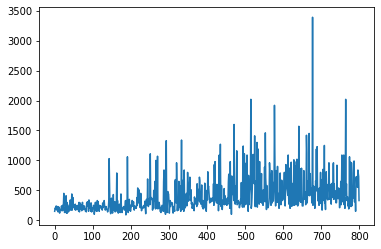

In [22]:
plt.plot(history)
plt.show()

In [23]:
def save_frames_as_gif(frames, path='./', filename='pacman_animation.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=240)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, fps=60)


MovieWriter ffmpeg unavailable; using Pillow instead.


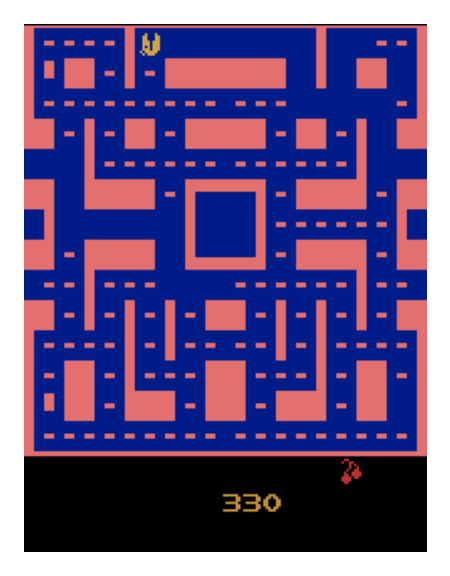

In [24]:
environment=gym.make('MsPacman-v0')
observation=environment.reset()
new_observation=observation

prev_input=None
done=False

with tf.compat.v1.Session() as sess:
    init.run()
    frames=[]
    while True:
        if True:
            observation=preprocess_observation(observation)
            actions=mainQ_outputs.eval(feed_dict={X:[observation],in_training_mode:False})
            
            action=np.argmax(actions,axis=-1)
            actions_counter[str(action)]+=1
            
            action=epsilon_greedy(action,global_step)
            frames.append(environment.render(mode="rgb_array"))
            observation=new_observation
            new_observation, reward, done, _=environment.step(int(action))
            if done:
                break
    save_frames_as_gif(frames)
    environment.close()
    
            

<img src="pacman_animation.gif" width="250" align="center">